# Documentation 
**Disclaimer**: *this document is not meant to be neither a formal nor an exhaustive description of the iterative method to solve the eigenvalue problem. The aim of this text is only to provide the necessary and minimal information needed for the reader to understand the code implementation. We will use these pages to document, explain and justify the choice made from a numerical and scientific computing standpoint*.

## Problem statement
Given a matrix $\boldsymbol{A} \in \mathbb{C}^{n, n}$, with $n \in \mathbb{N}$ the matrix dimension, the eigenvalue problem can be formulated as finding the eigenpair $\{(\lambda_i, \boldsymbol{v}_i)\}_{i=1} ^ n$, with $\lambda_i \in \mathbb{C}$, $\boldsymbol{v}_i \in \mathbb{C}^{n ,1}$ and $\boldsymbol{v}_i \ne \boldsymbol{0}$ such that 
$$\boldsymbol{A} \boldsymbol{v}_i = \lambda_i \boldsymbol{v}_i, \quad i=1, 2, ..., n $$

$\lambda_i$ are called eigenvalue, while $\boldsymbol{v}_i$ are the corresponding eigenvectors. Theoretically, finding the matrix's eigenvalues is possible by imposing the following condition:
$$ \det(A-\lambda I)=0 $$
which leads to the well known _characteristic polynomial_ of degree $n$ [[1](https://sissa-my.sharepoint.com/:b:/g/personal/glicausi_sissa_it/EeImU3eEs5hNoEF7hEnScxABpd0oMn5zOS8y-A3UJLoAGw?e=OO7IoE)]. Eigenvalues can then be described as the roots of the characteristic polynomial. Although theoretically correct, this approach is not viable in practice due to the difficulties in both expressing the characteristic polynomial and finding its roots in case of very large matrices.

Numerical methods address the eigenvalue problem using other approaches, most commonly through iterative methods. Instead of aiming for an exact solution, these methods focus on obtaining approximations that, under suitable conditions, are expected to converge to the true solution.
Among all the methods devolped to solve the eigenproblem, the power method, along with its variants suct that the inverse power method and power method with shift, and the QR algorithm are the widest spread and the most used [[1](https://sissa-my.sharepoint.com/:b:/g/personal/glicausi_sissa_it/EeImU3eEs5hNoEF7hEnScxABpd0oMn5zOS8y-A3UJLoAGw?e=OO7IoE)].

## Power method
Let $\boldsymbol{A}$ being a matrix and $\lambda _i$ the eigenvalue already sorted accordingly to their module. If
$$ |\lambda_1| > |\lambda _i | \quad i=2, 3, ..., n$$
then the power method allow to recover the eigenpair $(\lambda_1, \boldsymbol{v}_1)$ by applying iteratively, the following steps


$$
\begin{array}{l}
\textbf{Power Method Algorithm} \\
\textbf{Input:} A \in \mathbb{C}^{n \times n}, \text{initial vector } x_0, \text{ tolerance } \text{tol}, \text{ max iterations } \text{max\_iter} \\
\textbf{Output:} \lambda \text{ (dominant eigenvalue approximation), } x \text{ (eigenvector approximation)} \\

1.\ \text{Initialize } x = x_0 \text{ (random or chosen guess)} \\
2.\ \text{Normalize } x \text{: } y^{(1)} = x/ \| x\| \\
3.\ \lambda_{\text{old}} = 0 \\

4.\ \textbf{for } k = 1 \textbf{ to } \text{max\_iter} \textbf{ do} \\
\quad 5.\ x^{(k+1)} = A \cdot y^{(k)} \\
\quad 6.\  y^{(k+1)} = x^{(k+1)}/ \| x^{(k+1)}\|  \\
\quad 7.\  \lambda^{(k+1)} =  (y^{(k+1)})^H \boldsymbol{A} y^{(k+1)} \\
\quad 8.\ \textbf{if } |\lambda^{(k+1)} - \lambda^{(k)}| < \text{tol} \textbf{ then} \\
\quad \quad \text{Break (convergence reached)} \\

9.\ \textbf{Return } \lambda, x
\end{array}
$$

By exploiting Matrix properties, it is also possible to find the eigenvalue with the smallest norm, and its associated eigenvector, or the eigenvalue closest to a given value.


## QR algorithm
Despite its simplicity, the power method has its limitations. First of all, it only allows one to get an eigenpair at a time. Secondly, it does not exploit efficiently all the computation performed. At step $k$, the power method exploits only the information $ \beta \boldsymbol{A}^m \boldsymbol{x^0}  $, where $\beta$ is a given scaling factor. On the other hand, a quicker convergence and a better approximation of the eigenpair could be achieved by simply storing and making use of all the directions determined by the vectors   $\boldsymbol{A}^i \boldsymbol{x^0} $, with $ i $ up to the step $k$. Indeed, it is possible to collect them all in a matrix, called _Krylov matrix_ $K^m(x^0)$:
$$K^m(x^0)=[\boldsymbol{x^0}, \boldsymbol{A} \boldsymbol{x^0}, ..., \boldsymbol{A}^{m-1} \boldsymbol{x^0}]$$  
The space spanned by the columns of the Krylov matrix is called _Krylov subspace_ $\mathcal{K}^m$ [[2](https://sissa-my.sharepoint.com/my?id=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references%2F12%2Dkrylov%2Dsubspaces%2D1998%2Epdf&parent=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references)]. Using the Rayleigh-Rit procedure [[3](https://sissa-my.sharepoint.com/my?id=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references%2F11%2Dapproximations%2Dfrom%2Da%2Dsubspace%2D1998%2Epdf&parent=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references)] and the Krylov subspace, the number of iteration that it takes to achieve convergence is [[2](https://sissa-my.sharepoint.com/my?id=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references%2F12%2Dkrylov%2Dsubspaces%2D1998%2Epdf&parent=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references)]:
$$\frac{1}{2} \sqrt{n} \ln [200 \sqrt{n}]\left(\frac{1}{2} \sqrt{n} \ln 200\right)$$
Notice that the computational cost of the power method in terms of the matrix size $n$ is given by:
$$n \ln [100 \sqrt{n}](n \ln 100)$$

The QR algorithm makes implicit use of Krylov subspace. To introduce the method without hiding any important detail, let's start with a definition. A subspace $\mathcal{S^1}$ is said to be _invariant_ if $\mathcal{S^1}$ is mapped into itself by $\boldsymbol{A}$, i.e. $\boldsymbol{A}\mathcal{S^1} \subset \mathcal{S^1} $. In particular, if the subspace $\mathcal{S^1}$ is the space spanned by the whole set of eigenvectors, then $\boldsymbol{A}\mathcal{S^1} = \mathcal{S^1} $ [3].

Given a new orthogonal basis $\boldsymbol{Q}=[\boldsymbol{q_1}, \boldsymbol{q_2}, ..., \boldsymbol{q_n}] \in \mathbb{C}^{n, m} $, with $\boldsymbol{Q}^H \boldsymbol{Q}= \boldsymbol{I}$, it spans an invariant subspace if
$$\boldsymbol{R} (\boldsymbol{Q})=  \boldsymbol{A}\boldsymbol{Q}-\boldsymbol{Q} \boldsymbol{H}=\boldsymbol{0}$$ 
or
$$\boldsymbol{H} = \boldsymbol{Q} ^H \boldsymbol{A}\boldsymbol{Q}. $$ 
$\boldsymbol{H} $ and $ \boldsymbol{A}$ share the same eigenvalues $\lambda _ i $, and each eigenvector $\boldsymbol{y}$ of $\boldsymbol{H}$ determines an eigenvector $\boldsymbol{Q} \boldsymbol{y}$ of $\boldsymbol{A}$. Indeed:
$$\boldsymbol{H} \boldsymbol{y} =\boldsymbol{Q} ^H \boldsymbol{A}\boldsymbol{Q}  \boldsymbol{y} =  \boldsymbol{Q} ^H \lambda \boldsymbol{Q}  \boldsymbol{y} = \lambda  \boldsymbol{y}. $$


Now that the most basic definitions and properties have been introduced, we can present the QR algorithm, which is one of the most important algorithms in eigenvalue computations. It delivers all the eigenvalues, and eventually the eigenvectors of a given matrix, with an overall complexity of $O(n^3)$ [[4](https://sissa-my.sharepoint.com/personal/glicausi_sissa_it/Documents/PhD/Development%20Tools%20for%20Scientific%20Computing%20-%20Project%20material%20and%20references/chapter4.pdf?CT=1741959188709&OR=ItemsView)
]. For simplicity, the dissertation about the QR method will be split into two parts, covered in the following two sections.

### Reduction of the symmetric matrix into tridiagonal matrix
Even though the QR method (described in the next section) can be applied directly to the full symmetric matrix, it can be shown that the convergence of the method is slow, and each step is really expensive. Thus, in a sort of preprocessing phase, the original matrix $\boldsymbol{A}$ is reduced to a symmetric tridiagonal matrix $\boldsymbol{T}$ [4]. The advantages of $\boldsymbol{T}$ over $\boldsymbol{A}$ in the iteration process will be discussed later on.

There is an intimate connection between the Krylov subspaces and tridiagonal matrices. Indeed, there exists a particular orthonormal basis, $\boldsymbol{Q}=[\boldsymbol{q}_1, ...\boldsymbol{q}_n]$, which is the result of applying the Gram—Schmidt orthonormalization process to the columns of $K^m(\boldsymbol{q}_1)$ in the natural order $\boldsymbol{q}_1, \boldsymbol{A}\boldsymbol{q}_1, \, ....$. 

Suppose that $\boldsymbol{q}_1, \boldsymbol{q}_2, ..., \boldsymbol{q}_{i-1}$ are given, with $i<n$, then $\boldsymbol{q}_{i}$ can be obtained by orthonormalize $\boldsymbol{A}\boldsymbol{q}_{i-1}$ against  $\boldsymbol{q}_1, \boldsymbol{q}_2, ..., \boldsymbol{q}_{i-1}$ [2]. 

*When  $K^m(\boldsymbol{x}^o, \boldsymbol{A})$ has full rank,  then $\boldsymbol{T}=\boldsymbol{Q} ^H \boldsymbol{A}\boldsymbol{Q}$ is an unreduced tridiagonal matrix*[2].
$$
\boldsymbol{T}= \left[\begin{array}{ccccc}
\alpha_1 & \beta_1 & & & \\
\beta_1 & \alpha_2 & \beta_2 & & \\
& \beta_2 & \cdot & \cdot & \\
& & \cdot & \cdot & \beta_{n-1} \\
& & & \beta_{n-1} & \alpha_n
\end{array}\right]
$$

Where $\alpha_i=\boldsymbol{q}_i ^H \boldsymbol{A} \boldsymbol{q}_i$, and $\beta_i = \boldsymbol{q}_{i+1} ^H \boldsymbol{A} \boldsymbol{q}_i$.

The pseudocode that describes the basic Lanczos algorithm is shown below [6]. 

$$
\begin{aligned}
&\overline{\text { Basic Lanczos algorithm for the computation of an orthonormal }}\\
&\text { basis for of the Krylov space } \mathcal{K}^m(\mathrm{x})\\
&\text { Let } A \in \mathbb{F}^{n \times n} \text { be Hermitian. This algorithm computes the Lanczos relation (10.13), }\\
&\text { i.e., an orthonormal basis } Q_m=\left[\mathbf{q}_1, \ldots, \mathbf{q}_m\right] \text { for } \mathcal{K}^m(\mathbf{x}) \text { where } m \text { is the smallest index }\\
&\text { such that } \mathcal{K}^m(\mathbf{x})=\mathcal{K}^{m+1}(\mathbf{x}) \text {, and (the nontrivial elements of) the tridiagonal matrix }\\
&T_m \text {. }\\
&\mathbf{q}:=\mathbf{x} /\|\mathbf{x}\| ; \quad Q_1=[\mathbf{q}] ;\\
&\mathbf{r}:=A \mathbf{q} \text {; }\\
&\alpha_1:=\mathbf{q}^* \mathbf{r} ;\\
&\mathbf{r}:=\mathbf{r}-\alpha_1 \mathbf{q} \text {; }\\
&\beta_1:=\|\mathbf{r}\| ;\\
&\text { for } j=2,3, \ldots \text { do }\\
&\mathbf{v}=\mathbf{q} ; \quad \mathbf{q}:=\mathbf{r} / \beta_{j-1} ; \quad Q_j:=\left[Q_{j-1}, \mathbf{q}\right] ;\\
&\mathbf{r}:=A \mathbf{q}-\beta_{j-1} \mathbf{v} \text {; }\\
&\alpha_j:=\mathbf{q}^* \mathbf{r} \text {; }\\
&\mathbf{r}:=\mathbf{r}-\alpha_j \mathbf{q} ;\\
&\beta_j:=\|\mathbf{r}\| \text {; }\\
&\text { if } \beta_j=0 \text { then }\\
&\text { return }\left(Q \in \mathbb{F}^{n \times j} ; \alpha_1, \ldots, \alpha_j ; \beta_1, \ldots, \beta_{j-1}\right)\\
&\text { end if }\\
&\text { end for }
\end{aligned}
$$

Unfortunatly, this simple algorithm fails when the matrix dimension $n$ becomes larger than about as low as $10$ (in our experience). Indeed, daeling with finite precision arithmetic makes this method unstable and, as the iterations goes by, loss of orthogonality between elements of the basis is responsable for a spurious eigenvalue's multiplicity [5]. Examples of this phenomenon, error analyses, and workaround strategies are dealt with exhaustively in [5], [6], but those go beyond the scope of this discussion. Instead, we limit ourselves to picking the useful and relevant results.

Since we are performing a similarity transformation, it is important that the eigenvalues of $\boldsymbol{T}$ are as close as possible to the eigenvalues of $\boldsymbol{A}$. At the $j$-th step of the Lanczos algorithm, the following inequality holds [6]:
$$|\lambda_i - \theta_i^{(j)}|\le \beta_j |s_{ji}|.$$
The vector $\boldsymbol{s}^{(j)}_i$ is the eigenvector of $\boldsymbol{T^{(j)}}$ associated to the Ritz value $\theta_i^{(j)}$, and $s_{ji}$ is the projection of $\boldsymbol{s}^{(j)}_i$ onto the basis $\boldsymbol{e}_j$.
Two considerations are worth noting:
- A good approximation of some eigenvalues is possible even if $\beta_j$ differs from zero.
- At the final step, if the orthogonality of the basis is not lost due to numerical instabilities, $\beta_n=0$ and an exact correspondence between the eigenvalue (and the corresponding Ritz vector) of $\boldsymbol{T}$ and $\boldsymbol {A}$ ia achieved. (Naive explanation
: being $[\boldsymbol{q}_1, \boldsymbol{q}_2, ..., \boldsymbol{q}_n ]$ a complete basis, $\boldsymbol{A}\boldsymbol{q}_n$ doesn't add any new direction, which means that the residual is zero, and so is $\beta_n$, which is the norm of the residual).

An interesting fact is that the algorithm is inherently unstable. The loss of orthogonality happens as soon as Ritz vectors have converged accurately enough to the eigenvector [5]. To avoid loss of orthogonality, we can renormalize the new computed basis against all the previous available basis. If we perform the orthogonalization at each step of the Lanczos algorithm, we are applying the full re-orthogonalization technique. Then the eigenvalue of $\boldsymbol{T}$ is equal to the eigenvalue of $\boldsymbol{A}$, but applying the re-orthogonalization blindly is way too expensive.
Perturbation analysis, instead, suggests the scenarios when the re-orthogonalization is a necessity. In particular, if $\boldsymbol{q}_{j+1}^H\boldsymbol{i}> \sqrt{\epsilon _M}$, $i=1, 2,..., j-1$, then the vectors $\boldsymbol{q}_j$ $\boldsymbol{q}_{j+1}$ are orthogonalized against all previous Lanczos vectors  $\boldsymbol{q}_1, ..., \boldsymbol{q}_{j-1}$, with $\epsilon _M$ the machine precision. This procedure, called _Partial Re-Orthogonalization_, gives rise to our `Lanczos_PRO` function.

We refer to [5], [6] for perturbation analyses.

### Application of the algorithm to a tridiagonal Matrix 
Now we move on to the second step of the QR algorithm: the QR decomposition. This step is applicable only to tridiagonal matrices and follows the Lanczos reduction chronologically. There are two implementations of the QR algorithm. The first is straightforward but tends to converge slowly. The second implementation utilizes the Wilkinson Shift, which accelerates convergence (quadratically) and requires a slightly different approach than the original. Although the two implementations are similar, the implicit Wilkinson shift conceals some details that, if not understood, can leave the algorithm feeling somewhat mysterious.
Since we tested the two implementations implementations, we will briefly present both of them.

An important theorem, forming the cornestone of the method, is the following:

***The Hessenberg (Tridiagonal) form is preserved by the QR algorithms***

_If $\boldsymbol{Q}$ and $\boldsymbol{R}$ are the the QR factorization of $\boldsymbol{T}=\boldsymbol{Q}\boldsymbol{R}$, then $\boldsymbol{R}\boldsymbol{Q}$ is still a tridiagonal matrix._

The QR decomposition of $\boldsymbol{T}$ trasform the matrix in the product of a Hessemberg matrix $\boldsymbol{Q}$ and a upper triangular matrix $\boldsymbol{R}$. Starting with  $\boldsymbol{T}$, we need to put to zero the element below the diagonal. Accomplishing this is really simple thank to the Givens rotation, which is defined by
$$

\begin{array}{cccc}
G(i,j,\vartheta) & := &
    \begin{bmatrix}
    1 & \cdots & 0 & \cdots & 0 & \cdots & 0 \\
    \vdots & \ddots & \vdots & & \vdots & & \vdots \\
    0 & \cdots & c & \cdots & s & \cdots & 0 \\
    \vdots & & \vdots & \ddots & \vdots & & \vdots \\
    0 & \cdots & -s & \cdots & c & \cdots & 0 \\
    \vdots & & \vdots & & \vdots & \ddots & \vdots \\
    0 & \cdots & 0 & \cdots & 0 & \cdots & 1
    \end{bmatrix}  &
    \begin{matrix} 
\\
\\
	\leftarrow i \\
\\
	\leftarrow j \\
\\
\\
\end{matrix}  \\
& &
    \begin{matrix}
     & \uparrow &  & &  & \uparrow & \\
    & i &  & &  & j &
    \end{matrix} & \\
\end{array} 
$$

## Divide and conquer
In the previous chapter we have described the steps that lead to the solution of the eigenvalue problem by means of the QR algorithm. The computational cost for the tridiagonalization of the symmetric matrix is about $O(\frac{8}{3} n^3)$, while the pure QR algorithm applied to a tridiagonal matrix takes almost $O(6 n^3)$ to converge. Moreover, the QR algorithm as it is is difficult to parallellize as there is little room for the parallelization.

On the other hand, a faster (yet clever) algorithm exists and is based upon the old philosphy of *divide and conquer*. The main advantage of this new approach is its inclination to be easly parallelizable. In the *divide* step, we split the large matrix in two small, half-sized matrices. The eigenvalue problem of this two smaller systems is then solved, and the solution are then assembled following suitable rules in order to *conquer* the solution of the original larger system. The divide and conquer can be applied recursively until we reach a small matrix size for which the eigenvalue problem is easy to solve.

We start by splitting $T$ as
$$
T =
\left[
\begin{array}{c|c}
\begin{array}{ccccc}
a_1   & b_1   &        &        &                 \\
b_1   & a_2   & \ddots &        &                \\
      & \ddots& \ddots & \ddots &                 \\
      &       & \ddots & \ddots & b_{m-1}        \\
      &       &        & b_{m-1}& a_m            \\
\end{array}
&
\begin{array}{ccccc}
 \vphantom{a_{m+1}}   &   \vphantom{\ddots}  &        &        &                 \\
 \vphantom{a_{m+1}}   &   \vphantom{\ddots} &  &        &                \\
   \vphantom{a_{m+1}}    & \vphantom{\ddots} &  &  &                 \\
    \vphantom{a_{m+1}}   &   \vphantom{\ddots}    &  &  &         \\
b_m      &  \qquad     &    \qquad    & \qquad &      \qquad      \\
\end{array}
\\
\hline
\begin{array}{ccccc}
 \vphantom{a_{m+1}}   &    &        &        &     b_m            \\
 \vphantom{a_{m+1}}   &   \vphantom{\ddots} &  &        &                \\
   \vphantom{a_{m+1}}    & \vphantom{\ddots} &  &  &                 \\
    \vphantom{a_{m+1}}   &   \vphantom{\ddots}    &  &  &         \\
      &  \qquad     &    \qquad    & \qquad &      \qquad      \\
\end{array}
&
\begin{array}{ccccc}
a_{m+1} & b_{m+1} &        &        &         \\
b_{m+1} & a_{m+2} & \ddots &        &         \\
        & \ddots  & \ddots & \ddots &         \\
        &         & \ddots & \ddots & b_{n-1} \\
        &         &        & b_{n-1}& a_n     \\
\end{array}
\end{array}
\right]

\\
T
=
\left[
\begin{array}{c|c}
\begin{array}{ccccc}
a_1   & b_1   &        &        &                 \\
b_1   & a_2   & \ddots &        &                \\
      & \ddots& \ddots & \ddots &                 \\
      &       & \ddots & \ddots & b_{m-1}        \\
      &       &        & b_{m-1}& a_m \mp b_m     \\
\end{array}
&
\begin{array}{ccccc}
 \vphantom{a_{m+1}}   &   \vphantom{\ddots}  &        &        &                 \\
 \vphantom{a_{m+1}}   &   \vphantom{\ddots} &  &        &                \\
   \vphantom{a_{m+1}}    & \vphantom{\ddots} &  &  &                 \\
    \vphantom{a_{m+1}}   &   \vphantom{\ddots}    &  &  &         \\
\mp b_m      &  \qquad     &    \qquad    & \qquad &      \qquad      \\
\end{array}
\\
\hline
\begin{array}{ccccc}
 \vphantom{a_{m+1}}   &    &        &        & \mp b_m             \\
 \vphantom{a_{m+1}}   &   \vphantom{\ddots} &  &        &                \\
   \vphantom{a_{m+1}}    & \vphantom{\ddots} &  &  &                 \\
    \vphantom{a_{m+1}}   &   \vphantom{\ddots}    &  &  &         \\
      &  \qquad     &    \qquad    & \qquad &      \qquad      \\
\end{array}
&
\begin{array}{ccccc}
a_{m+1} \mp b_m & b_{m+1} &        &        &         \\
b_{m+1} & a_{m+2} & \ddots &        &         \\
        & \ddots  & \ddots & \ddots &         \\
        &         & \ddots & \ddots & b_{n-1} \\
        &         &        & b_{n-1}& a_n     \\
\end{array}
\end{array}
\right]
+
\left[
\begin{array}{cccc|cccc}
     &     &     &     &     &     &     &     \\
     &     &     &     &     &     &     &     \\
     &     &     &     &     &     &     &     \\
     &     &     &    \pm b_m & b_m    &     &     &     \\
\hline
     &     &     &   b_m  &  \pm b_m   &     &     &     \\
     &     &     &     &     &     &     &     \\
     &     &     &     &     &     &     &     \\
     &     &     &     &     &     &     &     \\
\end{array}
\right]
$$
$$
\boldsymbol{T} =\left[
\begin{array}{c|c}
\boldsymbol{T}_1 & \\ \hline
    & \boldsymbol{T}_2
\end{array}
\right]
+ \rho\, \mathbf{u} \mathbf{u}^T
$$
with 

$$

\mathbf{u} = 
\left[
\begin{array}{c}
\pm \mathbf{e}_m \\
\hline
\mathbf{e}_1
\end{array}
\right]

$$
and $\rho=\pm b_m$

The matrix $\boldsymbol{T}$ can be decomposed in the sum of a matrix made by a two diagonal blocks of tridiagonal matrices $\boldsymbol{T}_1$ and $\boldsymbol{T}_2$ and a rank-one correction represented by $\boldsymbol{u}$. Notice that $ m \simeq n/2$. The smaller eigenvalue problems are decoupled and therefore can be solved seprately, with any suitable algorithm. In particular, if we denote with $\boldsymbol{Q}_i$ the matrix containing the eigenvector of $\boldsymbol{T}_i$ and $\boldsymbol{\Lambda} _ i $ the diagonal matrix with the eigenvalues on the main diagonal, we can write.
$$
\boldsymbol{T}_i= \boldsymbol{Q}_i \boldsymbol{\Lambda} _ i \boldsymbol{Q} _i^H, \qquad i=1, \, 2
$$
It can soon be noted that the algorithm land itself well to parallelization since the two eigenvalue problem can be solved at the same time.


Using the previous two relations we can write

$$

[\,Q_1^T \mid Q_2^T\,]\,
\bigl([\,T_1 \mid T_2\,] + \rho\,u\,u^T\bigr)\,
\begin{bmatrix}Q_1\\[0.5ex]Q_2\end{bmatrix}
=
\begin{bmatrix}\Lambda_1\\[0.5ex]\Lambda_2\end{bmatrix}
+ \rho\,v\,v^T
$$

with

$$

v = \begin{bmatrix}Q_1^T\\[0.5ex]Q_2^T\end{bmatrix},
\quad
u = \begin{bmatrix}\pm\,Q_1^T e_m\\[0.5ex]Q_2^T e_1\end{bmatrix}
=
\begin{bmatrix}
\pm\text{ last row of }Q_1\\[0.5ex]
\text{first row of }Q_2
\end{bmatrix}.
$$


Now we have arrived at the eigenvalue problem

$$

(D + \rho\,v\,v^T)\,x = \lambda\,x,
\qquad
D = \Lambda_1 \oplus \Lambda_2 = \mathrm{diag}(\lambda_1,\dots,\lambda_n).
$$

That is, we have to compute the spectral decomposition of a matrix that is a **diagonal plus a rank-one update**. Let

$$

D + \rho\,v\,v^T = Q\,\Lambda\,Q^T
$$

be this spectral decomposition. Then, the spectral decomposition of the tridiagonal $T$ is

$$

T = [\,Q_1 \mid Q_2\,]\,Q\,\Lambda\,Q^T\,
\begin{bmatrix}Q_1^T\\[0.5ex]Q_2^T\end{bmatrix}.
$$

Forming the product $(Q_1 \oplus Q_2)\,Q$ will turn out to be *the most expensive step of the algorithm*. It costs

$$
n^3 + O(n^2)
$$

floating-point operations.

For further detail about the algorithm, like strategies to solve the secular equation, please refer to [7].


# Tradeoff accuracy vs time

The pipeline for computing the eigenvalues and eigenvectors of a symmetric matrix using our proposed method is as follows:

```mermaid
flowchart LR
start[Symmetric matrix] -->id1[tridiagonal matrix]-->
id2[divide and conquer]-->id3[QR algorithm];

```
Each algorithm in the pipeline is governed by a tolerance parameter that influences the solution quality. To isolate the sensitivity of the final eigenvalues and eigenvectors to these tolerances, we varied one parameter at a time and observed how the accuracy of the eigenvalue computation changed.


## Lanczos Alogrithm

```mermaid
flowchart LR
start[Symmetric matrix] --> |Lanczos| id1[tridiagonal matrix];
```
As described in the section on the Lanczos algorithm, the tolerance parameter controls the loss of orthogonality among the basis vectors. This threshold determines when two vectors may be considered orthogonal or not. Below, we present a set of tests demonstrating the algorithm’s performance; additional test cases can be found in the `test` folder. The accompanying `Python` code is fully commented so that readers can follow each step without difficulty.


In [1]:
from pyclassify import EigenSolver
from pyclassify.cxx_utils import QR_algorithm
from pyclassify.utils import make_symmetric
import numpy as np
from time import time
import matplotlib.pyplot as plt

n=10
np.random.seed(42)
matrix = np.random.rand(n, n)
A=make_symmetric(matrix)
#step 1
#Check that Lanczos Alogrithm works well

#creating the object of tha class
eig_obj=EigenSolver(A)

#reducing the symmetric matrix to a tridiagonal matrix

Q, d, off_d=eig_obj.Lanczos_PRO()

#The matrix A and the trdiagonal should have the same spectrum

npEig_val, npEig_vec=np.linalg.eigh(A)

T=np.diag(d) + np.diag(off_d, 1) + np.diag(off_d, -1)
LaEig_val, LaEig_vec=np.linalg.eigh(T)

#check if the eigenvalues are the same
print(f"The maximum of the difference between the eigenvalue of A and the eigenvalue of {np.linalg.norm(npEig_val-LaEig_val, np.inf)}")

#checking that the unitary matrix Q is correct as well. The decomposition is such that A= Q' T Q (where ' denotes the transpose o)

print(f"The maximum absoulute error in the decomposition is equal to {np.max(np.abs(A-Q.T@T@Q))}")

# Validation of the 
QREig_val, QREig_vec= QR_algorithm(d, off_d)
index_sort=np.argsort(QREig_val)
QREig_vec=np.array(QREig_vec)
QREig_val=np.array(QREig_val)
QREig_vec=QREig_vec[:, index_sort]
QREig_val=QREig_val[index_sort]
print(f"The maximum of the difference between the eigenvalue computed by numpy on A and the developed QR algorithm computed"
       f"on the Matrix T is {np.linalg.norm(npEig_val-QREig_val, np.inf)}")


def check_column_directions(A, B):
    """
    Takes in input two matrices that cointains the eigenvectors. If the eigenvectors that referes to the same eigenvalue point in opposite directions, then the eigenvector In
    B is aligned with the one in A
    """
    n = A.shape[1]
    for i in range(n):
        # Normalize the vectors
        a = A[:, i]
        b = B[:, i]
        dot = np.dot(a, b)
        # Should be close to 1 or -1
        if dot<0:
            B[:, i] = -B[:, i]


check_column_directions(QREig_vec, LaEig_vec )
print(f"The maximum absoulute error among the components of all the eigenvectors of T is {np.max(np.abs(QREig_vec - LaEig_vec))}")


The maximum of the difference between the eigenvalue of A and the eigenvalue of 1.7763568394002505e-15
The maximum absoulute error in the decomposition is equal to 1.3328338432927467e-10
The maximum of the difference between the eigenvalue computed by numpy on A and the developed QR algorithm computedon the Matrix T is 1.7763568394002505e-15
The maximum absoulute error among the components of all the eigenvectors of T is 1.867801330268648e-09


For a fixed tolerance, we investiagated how the computation time scales with respect to the matrix size.

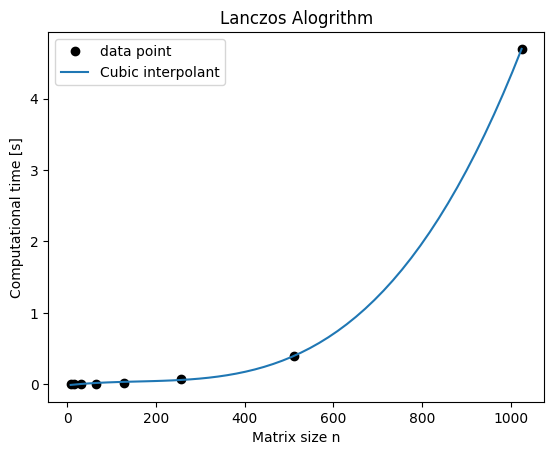

In [2]:
# Fixing the tolerance we see how the time scale in function of the matrix size

i_max=11
time_vector=np.array([])
for i in range(3, i_max):
    n=2**i
    np.random.seed(42)
    matrix = np.random.rand(n, n)
    A=make_symmetric(matrix)
    q=np.ones(n)
    t_s=time()
    eig_obj.Lanczos_PRO(A, q)
    t_e=time()
    time_vector=np.append(time_vector, t_e - t_s)

p=np.polyfit([2**i for i in range(3, i_max)], time_vector, 3)
plt.plot([2**i for i in range(3, i_max)], time_vector, 'ko')
x=np.linspace(2**3, 2**(i_max-1))
plt.plot(x, np.polyval(p, x))
plt.ylabel("Computational time [s]")
plt.xlabel("Matrix size n")
plt.legend(["data point", "Cubic interpolant"])
plt.title("Lanczos Alogrithm")
plt.show()

Now, we show how varying the tolerance impacts computational time, solution accuracy, and the number of eigenvectors that are not perfectly orthogonal.


<>:57: SyntaxWarning: invalid escape sequence '\e'
<>:57: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_7582/788143878.py:57: SyntaxWarning: invalid escape sequence '\e'
  axs[2].set_xlabel('Tolerance ($\epsilon$)', fontsize=15, fontweight='bold')


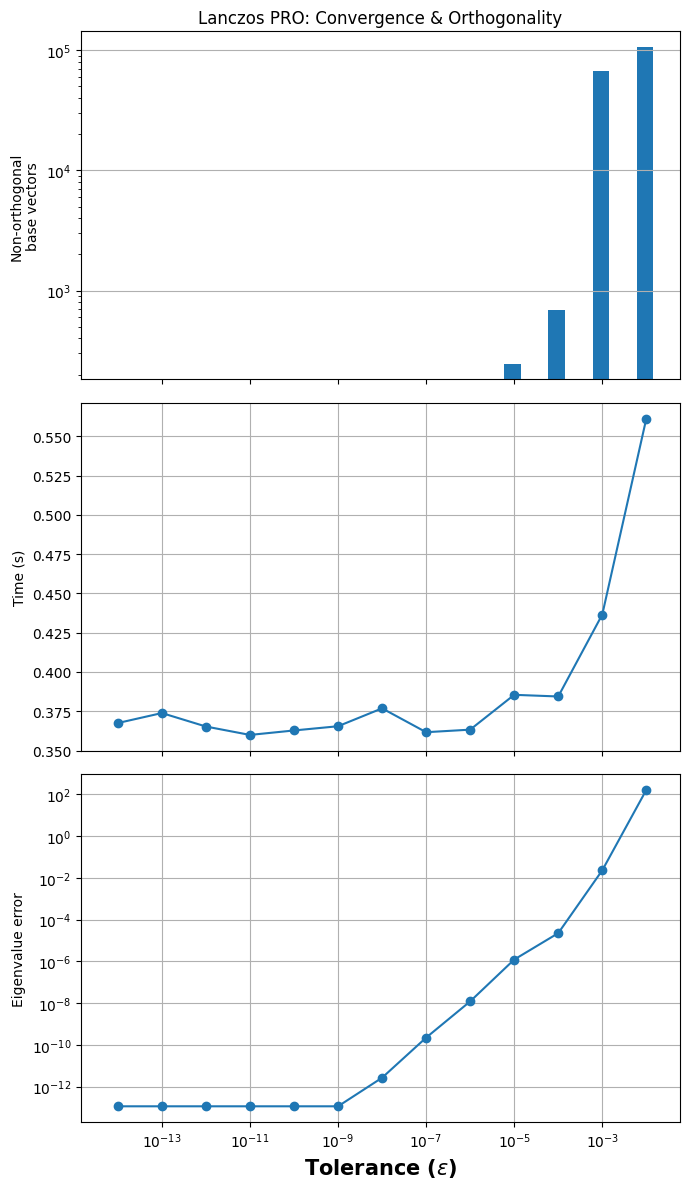

In [3]:
# generate the matrix and compute the reference eigenvalues
n=2**9
np.random.seed(42)
matrix = np.random.rand(n, n)
A=make_symmetric(matrix)
npEig_val, _=np.linalg.eigh(A)
q=np.ones(n)
eps=1e-15
Q, d, off_d=eig_obj.Lanczos_PRO(A, q, tol=eps)

#generating the vector of tolerances
eps=[10**(-i) for i in range(2, 15)]
threshold=1e-6
tolerance_time_vector=np.array([])
number_of_nonOrtBase=np.array([])
error_eigenvalue=np.array([])
#computing the quantities of interest like elapsed time and the error among the eigenvalues
for tol in eps:
    t_s=time()
    Q, d, off_d=eig_obj.Lanczos_PRO(A, q, tol=tol)
    t_e=time()
    T=np.diag(d) + np.diag(off_d, 1) + np.diag(off_d, -1)
    LaEig_val, _ =np.linalg.eigh(T)
    tolerance_time_vector=np.append(tolerance_time_vector, t_e - t_s)
    error_eigenvalue=np.append(error_eigenvalue, np.linalg.norm(np.abs(npEig_val-LaEig_val), np.inf))
    #loss of orthogonality
    G=Q@Q.T
    G=np.abs(G-np.tril(G))
    G=G > threshold
    count = np.sum(G)
    number_of_nonOrtBase=np.append(number_of_nonOrtBase, count)

fig, axs = plt.subplots(3, 1, figsize=(7, 12), sharex=True)

# 1. Number of non-orthogonal base vectors
axs[0].bar(eps, number_of_nonOrtBase, width=0.8*np.array(eps), align='center')
axs[0].set_ylabel('Non-orthogonal\nbase vectors')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].grid(True, axis='y')
axs[0].set_title('Lanczos PRO: Convergence & Orthogonality')

# 2. Time vs Tolerance
axs[1].plot(eps, tolerance_time_vector, marker='o')
axs[1].set_ylabel('Time (s)')
axs[1].set_xscale('log')
axs[1].grid(True)

# 3. Error in eigenvalue (log-log)
axs[2].plot(eps, error_eigenvalue, marker='o')
axs[2].set_ylabel('Eigenvalue error')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].grid(True, which="both")

#Shared, thick x-axis label only at the bottom
axs[2].set_xlabel('Tolerance ($\epsilon$)', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

First, we comment on the timing results. When the tolerance is very low (below $1\times 10^{-7}$), the execution time remains essentially constant. This is likely because a low tolerance triggers only a few orthogonality corrections during the early iterations; once those are performed, the algorithm proceeds without further adjustments, so the total cost stays the same. In contrast, a higher tolerance defers most corrections to later stages, when the Lanczos basis is larger - making each correction more expensive - and thus leads to longer runtimes. This explains the counterintuitive increase in execution time as the tolerance is loosened.

Next, we examine accuracy. Lowering the tolerance predictably improves the solution: the error decreases roughly linearly until $\varepsilon = 1\times 10^{-9}$, beyond which it plateaus.

Finally, the first plot shows the number of eigenvector pairs whose dot product exceeds $1\times 10^{-6}$, giving a measure of loss of orthogonality.

Based on these observations, we recommend using a tolerance of $\varepsilon = 1\times 10^{-9}$ for the Lanczos algorithm.

## QR algorithm
Since the accuracy of the QR method has already been validated, the remaining task is to evaluate the algorithm’s computational cost and analyze the trade-off between tolerance and execution time.


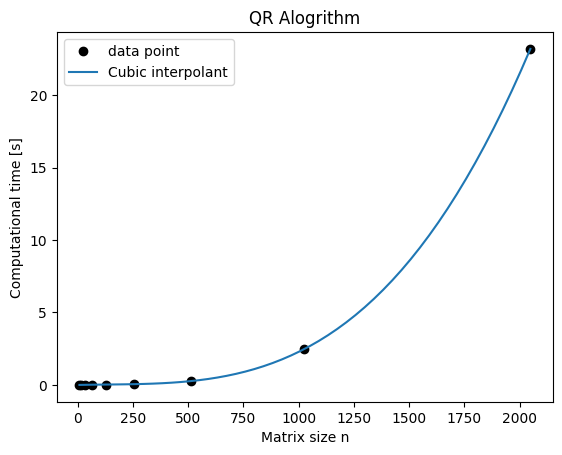

In [4]:

#Time scaling QR

i_max = 12

time_vector = np.array([])
error_eigenvalue = np.array([])
for i in range(3, i_max):
    n = 2**i
    # np.random.seed(42)
    d = np.random.rand(n)
    off_d = np.random.rand(n - 1)
    T = np.diag(d) + np.diag(off_d, 1) + np.diag(off_d, -1)
    npEig_val, _ = np.linalg.eigh(T)
    t_s = time()
    QREig_val, QREig_vec = QR_algorithm(d, off_d)
    t_e = time()
    index_sort = np.argsort(QREig_val)
    QREig_vec = np.array(QREig_vec)
    QREig_val = np.array(QREig_val)
    QREig_vec = QREig_vec[:, index_sort]
    QREig_val = QREig_val[index_sort]
    error_eigenvalue = np.append(
        error_eigenvalue, np.linalg.norm(np.abs(npEig_val - QREig_val), np.inf)
    )
    time_vector = np.append(time_vector, t_e - t_s)

p = np.polyfit([2**i for i in range(3, i_max)], time_vector, 3)
plt.plot([2**i for i in range(3, i_max)], time_vector, "ko")
x = np.linspace(2**3, 2 ** (i_max - 1))
plt.plot(x, np.polyval(p, x))
plt.ylabel("Computational time [s]")
plt.xlabel("Matrix size n")
plt.legend(["data point", "Cubic interpolant"])
plt.title("QR Alogrithm")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

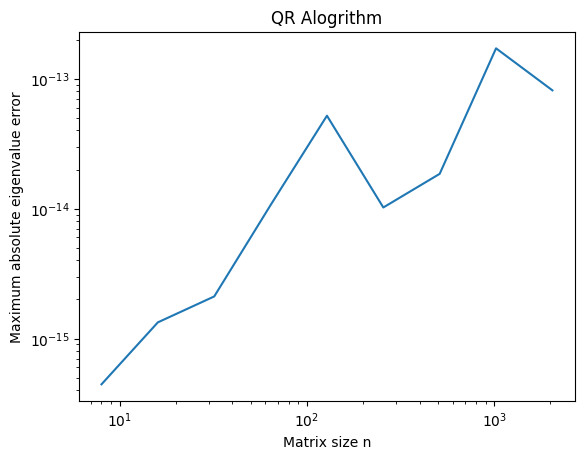

In [5]:

plt.loglog(2**np.arange(3, i_max), error_eigenvalue)
plt.ylabel("Maximum absolute eigenvalue error")
plt.xlabel("Matrix size n")
plt.title("QR Alogrithm")
plt.show

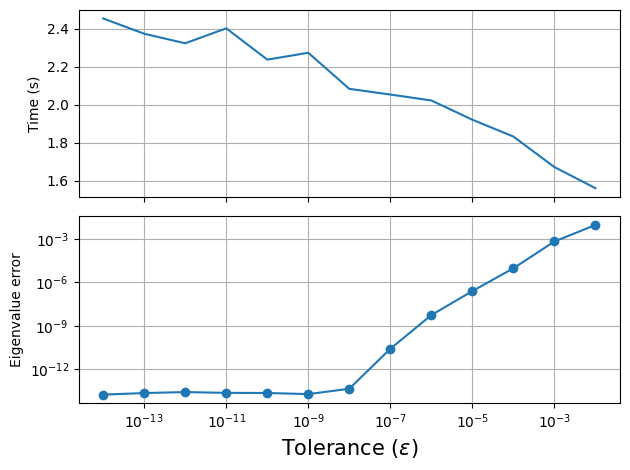

In [6]:
# genereating the matrix and its reference solution
n=2**10
np.random.seed(42)
d = np.random.rand(n)
off_d=np.random.rand(n-1)
eps=[10**(-i) for i in range(2, 15)]
T=np.diag(d) + np.diag(off_d, 1) + np.diag(off_d, -1)
npEig_val, _ =np.linalg.eigh(T)

tolerance_time_vector=np.array([])
error_eigenvalue=np.array([])
for tol in eps:
    t_s=time()
    QREig_val, QREig_vec= QR_algorithm(d, off_d, tol=tol)
    t_e=time()
    index_sort=np.argsort(QREig_val)
    QREig_vec=np.array(QREig_vec)
    QREig_val=np.array(QREig_val)
    QREig_vec=QREig_vec[:, index_sort]
    QREig_val=QREig_val[index_sort]
    tolerance_time_vector=np.append(tolerance_time_vector, t_e - t_s)
    error_eigenvalue=np.append(error_eigenvalue, np.linalg.norm(np.abs(npEig_val-QREig_val), np.inf))
    #loss of orthogonality



fig, axs=plt.subplots(2, 1, sharex=True, )
axs[0].plot(eps, tolerance_time_vector)
axs[0].set_ylabel('Time (s)')
axs[0].set_xscale('log')
axs[0].grid(True, which="both")

axs[1].plot(eps, error_eigenvalue, marker='o')
axs[1].set_ylabel('Eigenvalue error')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].grid(True, which="both")
axs[1].set_xlabel(r'Tolerance ($\epsilon$)', fontsize=15)
plt.tight_layout()
plt.show()

As shown in the plot, computation time increases as the tolerance is tightened. The maximum eigenvalue error decreases linearly until it plateaus at ε = 10⁻⁸, making this the optimal QR tolerance.



# Profiling of Divide and Conquer (memory and time)
We discuss the results of the profiling of the Divide et Impera algorithm.
Profiling is performed using the `submit.sh` file in the `shell` folder, which internally calls `scripts/profiling_memory_and_time.py`. 
We begin by discussing the memory consumption of the method, studying how it varies with respect to the matrix size and number of processes, and comparing it to `numpy`'s and `scipy`'s `eig` built-in function.

*IMPORTANT*: please notice that we did not use `scipy.sparse`'s solver as it cannot be used to retrieve all the eigenvalues, which would have make the comparison unfair.

![Memory profiling](plots/memory_profiling.png)

It is possible to see that cumulative memory consumption increases as the number of processes does.

Now we do the same for runtime vs matrix size and number of processes.

![Time profiling](plots/time_profiling.png)

Based on the previous plot, we would be tempted to say that not only the execution time is much bigger that it is for `numpy` and `scipy`, but also that our method does not scale with respect to the number of processes.
However, running a single time the file `shell/time_profile.sh`, we notice that this is likely a problem related to how `time.time()` saves the results.

Running, for instance,
```bash
$ shell/time_profile.sh 1 1500 # 1 refers to n_procs, 1000 to the matrix size
```
we get the following results:
```mermaid
[D&I] Total execution time: 0.3199 s
[NumPy] Total execution time: 0.0388 s
[SciPy] Total execution time: 0.0690 s
```
Re-running with `n_procs=2`, we obtain
```mermaid
[D&I] Total execution time: 0.2230 s
[NumPy] Total execution time: 0.8741 s
[SciPy] Total execution time: 0.0364 s
```
Finally, for `n_procs=4`, we obtain
```mermaid
[D&I] Total execution time: 0.1842 s
[NumPy] Total execution time: 0.0768 s
[SciPy] Total execution time: 0.0362 s
```
(notice that there is some variance in the times taken by the other two methods as a result of the fact that `time.time()` is not extremely robust).

The previous results suggest that the method scales well with the number of processes, and that the performance (while worse than `numpy` and `scipy`) is such that the comparison goes much better than it seemed to do earlier.
We believe that the reason for such a behavior is related to the execution of multiple scripts, which can have an impact on execution times as measured with `time.time()`.

Notice that we parallelized everything that could be parallelized (except for the secular solver, which usually takes no more than $5\%$ of the total time): the bottleneck is given by the Lanczos method, which cannot be parallelized.
If the Lanczos method is not needed (that is, if the matrix $A$ of which we want to compute the eigenvalues and eigenvectors is already tridiagonal), then the execution time of our solver becomes comparable to the one of `numpy` and `scipy`.

*Remark*: in the plot used to profile execution times, the Lanczos method takes bigger values than D&I when just one process is used.
Of course this is not possible, since D&I includes Lanczos.
However, the value that we plot for all the functions not depending on `n_procs` (including the ones of `numpy` and `scipy` and Lanczos) is the average across all the runs with different numbers of processes.
As a result, similar to what was remarked earlier for `numpy`'s eigenvalues solver, the execution time for large values of `n_procs` seems to increase, causing the average to become bigger, eventually getting bigger than D&I. 
However, notice that also this time running a single simulation with `shell/time_profile.sh` tells us that this is not truly the case, and that the execution time of the Lanczos algorithm remains pretty much the same as the number of processes increases. 

# A note on the code in C++
As anticipated in the `README.md` file, a few functions have been written in `C++` and have then been exposed to `Python` using `pybind11`.
The reason for this choice is the following one: either compiling them with `numba` offered no major performance advantage, or it was simply not possible as a result of the fact that some types that we used (e.g. `SciPy`'s sparse matrices) are not compatible with `numba`.

The cell below provides a comparison of the execution time of the original `Python` implementation and the `C++` one.

In [10]:
from pyclassify.cxx_utils import secular_solver_cxx
from pyclassify.zero_finder import secular_solver_python

seed = 2206
np.random.seed(seed)

n = 1000
d = np.arange(n)
rho = 2.
D = np.diag(d)
v = np.random.rand(n)

indices = range(len(d))
rk_1_update = rho * np.outer(v, v)
L = D + rk_1_update

begin_cxx = time()
computed_eigs_cxx, _, __ = secular_solver_cxx(rho, d, v, indices)
end_cxx = time()
duration_cxx = end_cxx - begin_cxx

begin_python = time()
computed_eigs_python, _, _ = secular_solver_python(rho, d, v) 
end_python = time()
duration_python = end_python - begin_python

print(f'Speedup: {duration_python/duration_cxx}')

exact_eigs, _ = np.linalg.eig(L)
exact_eigs = np.sort(exact_eigs)

for i in range(len(exact_eigs)):
    # Assert that the C++ eigenvalues are correct
    assert (
        np.abs(computed_eigs_cxx[i] - exact_eigs[i]) < 1e-8
    ), "Error. The eigenvalues were not computed correctly."
    # Also assert that they are close to the Python ones
    assert (
            np.abs(computed_eigs_cxx[i] - computed_eigs_python[i]) < 1e-8
        ), "Error. The eigenvalues were not computed correctly."

Speedup: 13.678840393068114


# Final remarks
We hope this file, along with the `README.md`, provides sufficient information to understand the work done in our project.
If anything remains unclear, feel free to reach out: we’ll be happy to answer any questions you may have.


## References
[1] [Panju, Maysum. "Iterative methods for computing eigenvalues and eigenvectors." arXiv preprint arXiv:1105.1185 (2011).](https://sissa-my.sharepoint.com/:b:/g/personal/glicausi_sissa_it/EeImU3eEs5hNoEF7hEnScxABpd0oMn5zOS8y-A3UJLoAGw?e=OO7IoE)

[2] [Parlett, Beresford N. The symmetric eigenvalue problem - Chapter 12. Society for Industrial and Applied Mathematics, 1998.](https://sissa-my.sharepoint.com/my?id=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references%2F12%2Dkrylov%2Dsubspaces%2D1998%2Epdf&parent=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references)

[3] [Parlett, Beresford N. The symmetric eigenvalue problem - Chapter 11. Society for Industrial and Applied Mathematics, 1998.](https://sissa-my.sharepoint.com/my?id=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references%2F11%2Dapproximations%2Dfrom%2Da%2Dsubspace%2D1998%2Epdf&parent=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references)

[4] [Arbenz, Peter. Lecture Notes on Solving Large Scale Eigenvalue Problems - Chapter 4. Computer Science Department, ETH Zürich, Spring semester 2016.](https://sissa-my.sharepoint.com/personal/glicausi_sissa_it/Documents/PhD/Development%20Tools%20for%20Scientific%20Computing%20-%20Project%20material%20and%20references/chapter4.pdf?CT=1741959188709&OR=ItemsView)

[5] [Parlett, Beresford N. The symmetric eigenvalue problem - Chapter 13. Society for Industrial and Applied Mathematics, 1998.](https://sissa-my.sharepoint.com/personal/glicausi_sissa_it/Documents/PhD/Development%20Tools%20for%20Scientific%20Computing%20-%20Project%20material%20and%20references/13-lanczos-algorithms-1998.pdf?CT=1741964477462&OR=ItemsView)

[6] [Arbenz, Peter. Lecture Notes on Solving Large Scale Eigenvalue Problems - Chapter 10. Computer Science Department, ETH Zürich, Spring semester 2016.](https://sissa-my.sharepoint.com/personal/glicausi_sissa_it/Documents/PhD/Development%20Tools%20for%20Scientific%20Computing%20-%20Project%20material%20and%20references/chapter10.pdf?CT=1741959176514&OR=ItemsView)

[7] [Arbenz, Peter. Lecture Notes on Solving Large Scale Eigenvalue Problems - Chapter 5-6. Computer Science Department, ETH Zürich, Spring semester 2016.](https://sissa-my.sharepoint.com/my?FolderCTID=0x012000B3941AA86D63224F9CC9A5B1FEDCCF3B&id=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references%2Fchapters5%2D6%2Epdf&parent=%2Fpersonal%2Fglicausi%5Fsissa%5Fit%2FDocuments%2FPhD%2FDevelopment%20Tools%20for%20Scientific%20Computing%20%2D%20Project%20material%20and%20references)